In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re

In [2]:
tweets = pd.read_csv("cleaned_data/2022-11-07_clean.csv")

In [3]:
tweets

,Unnamed: 0,parsed_created_at,user_screen_name,text,tweet_type,hashtags,favorite_count,retweet_or_quote_screen_name,user_id,user_default_profile_image,user_description,user_favourites_count,user_followers_count,user_friends_count,user_location,user_time_zone,user_verified,clean_text,language_spacy
0,0,2022-11-07T16:51:43+00:00,3112020C,@MonicaCrowley Sorry he will still be your Pre...,reply,GOP Midterms2022 BlueWave2022,0,NaN,1080766500552740865,False,💙💛🇺🇦#standwithUkraine 🇺🇸❤️ 💙proud independent ...,1686,1781,2568,"Massachusetts, USA",NaN,False,@MonicaCrowley Sorry he will still be your Pre...,en
1,1,2022-11-07T16:51:43+00:00,michael_fohey,𝕄𝕀𝔻𝕋𝔼ℝ𝕄𝕊 🗳 What State do you think will have...,retweet,Midterms2022,15,AskMeLaterOn,822879391474733056,False,NRA Member Army Veteran Retired from General...,104950,3649,4885,"Texas, USA",NaN,False,MIDTERMS :ballot_box_with_ballot: What State...,en
2,2,2022-11-07T16:51:44+00:00,PublicFreedom,"With the 2022 Mid-Term Elections upon us, Publ...",original,NaN,0,NaN,37701490,False,#ULTRAMAGA #KAG2020 Pro-Trump-Policy! Public A...,3054,5812,6222,"Washington, DC",NaN,False,"With the 2022 Mid-Term Elections upon us, Publ...",en
3,3,2022-11-07T16:51:47+00:00,BobSanford13,#POLLS | Trafalgar Final Georgia Poll: SEN (...,retweet,POLLS,5,ElAmerican_,895111538612350976,False,Patriotic,36156,895,1799,NaN,NaN,False,#POLLS | Trafalgar Final Georgia Poll: SEN (...,en
4,4,2022-11-07T16:51:48+00:00,MegaRedWave,Election day is tomorrow! Follow along as we l...,retweet,NaN,4,AdImpact_Pol,1252937499778912256,False,Elections geek. Conservatarian Republican. DeS...,3719,777,2777,"Virginia, USA",NaN,False,Election day is tomorrow! Follow along as we l...,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523789,526560,2022-09-22T00:13:06+00:00,Christ357099742,"Will they get away with this, again? #Electi...",retweet,Election2022,1247,45LVNancy,1155135459372277760,False,"🇺🇸🪕Vet 101st 2nd 327th. PaPou, Patriot. Live t...",11189,818,517,Way back in the hills. Ky,NaN,False,"Will they get away with this, again? #Electi...",en
523790,526561,2022-09-22T00:13:14+00:00,lisalisa365,@SenSanders Wtf should the US Senate be wastin...,retweet,NaN,1,Crogunsmith,2405211005,False,NaN,301738,1704,449,NaN,NaN,False,@SenSanders Wtf should the US Senate be wastin...,en
523791,526562,2022-09-22T00:13:18+00:00,eclvvin1,@RonDeSantisFL broke #immigration protocols. I...,retweet,immigration Republicans,4,forprogress_org,1221476175886921729,False,"It's not what you think, it's what you do",1423,24,113,NaN,NaN,False,@RonDeSantisFL broke #immigration protocols. I...,en
523792,526563,2022-09-22T00:13:20+00:00,aFathersLog,They would love to coup Lula and keep Bolsonar...,retweet,NaN,232,KyleKulinski,702367729588768768,False,"Father, author, husband, poet, and writer of t...",39714,1023,975,United States,NaN,False,They would love to coup Lula and keep Bolsonar...,en


In [4]:
# Remove tweets with no hashtags
hashtag_tweets = tweets.loc[~tweets['hashtags'].isna()]
hashtag_tweets = hashtag_tweets[['parsed_created_at',"hashtags"]]

# Put hashtags into lists
hashtag_tweets['hashtags_split'] = [hashtags.lower().split(" ") for hashtags in hashtag_tweets['hashtags']]

# Create unique rows for tweets with multiple hastags
hashtag_tweets.drop(['hashtags'], inplace=True, axis=1)
hashtag_tweets = hashtag_tweets.explode('hashtags_split')

# Remove the hashtags that were used for sampling
hashtag_tweets = hashtag_tweets.loc[~hashtag_tweets['hashtags_split'].isin(['midterms2022','midtermelections', 'election2022'])]
hashtag_tweets['date'] = pd.to_datetime(hashtag_tweets['parsed_created_at']).dt.date

In [5]:
# Group by hashtag to find number of tweets per tag per day
grouped_hashtags = hashtag_tweets.groupby(['hashtags_split','date']).size().to_frame('size').reset_index()

In [6]:
# Find overall most used tags
all_dates_hashtags = grouped_hashtags.groupby(['hashtags_split']).agg({'size':'sum'}).reset_index().sort_values('size', ascending=False)

In [7]:
# Intersting sample case
list(tweets.loc[tweets['hashtags'] == 'DISCLOSE']['clean_text'])[0]

"BREAKING: Senate Republicans just filibustered the #DISCLOSE Act to combat the flood of anonymous special interest spending in our elections--meaning they don't want the American people to see who is attempting to sway our elections and gain control over our government."

In [8]:
# Filter for just the most popular tags
selected_hashtags = grouped_hashtags.loc[grouped_hashtags['hashtags_split'].isin(list(all_dates_hashtags['hashtags_split'])[:10])]

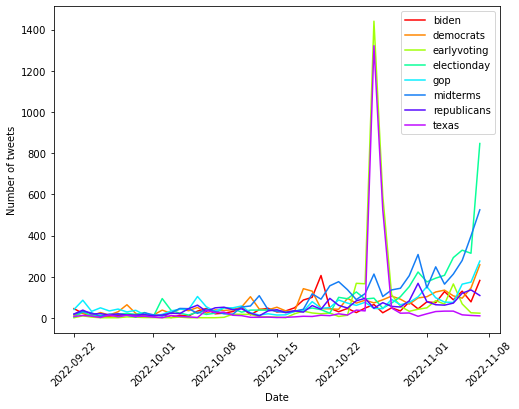

In [9]:
# Plots below display the popularity of hashtags over time, different opacity is used for different patterns
fig, ax = plt.subplots(figsize = (8,6))
plot_hashes = selected_hashtags['hashtags_split'].unique()
colors = [r"#ff0000","#ff8700","#deff0a","#a1ff0a","#0aff99","#0aefff","#147df5","#580aff","#be0aff"]

hashes = selected_hashtags["hashtags_split"].values
counts = selected_hashtags["date"].values
dates = selected_hashtags["size"].values

for hash, color in zip(plot_hashes,colors):
    if hash != "disclose":
        idxs = np.where(hashes == hash)
        ax.plot(counts[idxs], dates[idxs], label = hash, c=color)

ax.set_xlabel('Date')
ax.set_ylabel('Number of tweets')
plt.xticks(rotation = 45)
ax.legend(loc=0)

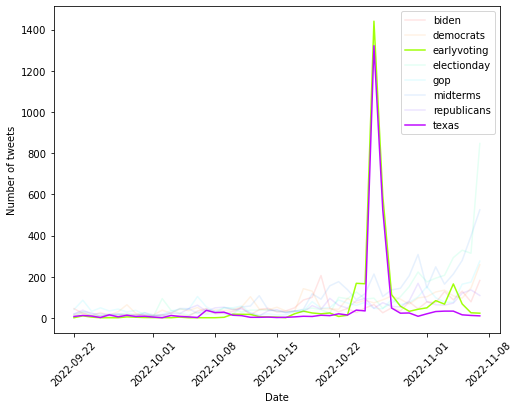

In [23]:
fig, ax = plt.subplots(figsize = (8,6))
plot_hashes = selected_hashtags['hashtags_split'].unique()
colors = ["#ff0000","#ff8700","#deff0a","#a1ff0a","#0aff99","#0aefff","#147df5","#580aff","#be0aff"]

hashes = selected_hashtags["hashtags_split"].values
counts = selected_hashtags["date"].values
dates = selected_hashtags["size"].values

for hash, color in zip(plot_hashes,colors):
    if hash != "disclose":
        if hash in ['texas','earlyvoting']:
            idxs = np.where(hashes == hash)
            ax.plot(counts[idxs],dates[idxs], label = hash, c=color)
        else:
            idxs = np.where(hashes == hash)
            ax.plot(counts[idxs],dates[idxs], label = hash, c=color, alpha = 0.1)

ax.set_xlabel('Date')
ax.set_ylabel('Number of tweets')
plt.xticks(rotation = 45)
ax.legend(loc=0)

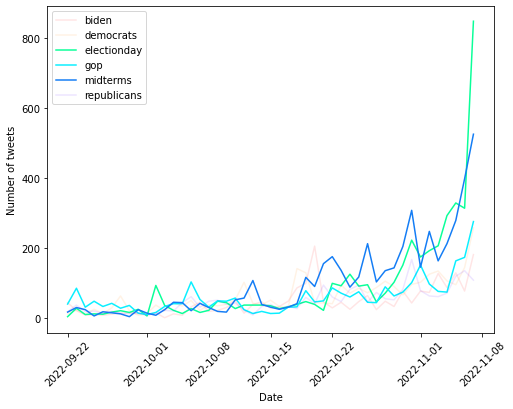

In [28]:
fig, ax = plt.subplots(figsize = (8,6))
plot_hashes = selected_hashtags['hashtags_split'].unique()
colors = ["#ff0000","#ff8700","#deff0a","#a1ff0a","#0aff99","#0aefff","#147df5","#580aff","#be0aff"]

hashes = selected_hashtags["hashtags_split"].values
counts = selected_hashtags["date"].values
dates = selected_hashtags["size"].values

for hash, color in zip(plot_hashes,colors):
    if hash not in ["disclose", "texas", "earlyvoting"]:
        if hash in ["midterms","electionday","gop"]:
            idxs = np.where(hashes == hash)
            ax.plot(counts[idxs],dates[idxs], label = hash, c=color)
        else:
            idxs = np.where(hashes == hash)
            ax.plot(counts[idxs],dates[idxs], label = hash, c=color, alpha = 0.1)

ax.set_xlabel('Date')
ax.set_ylabel('Number of tweets')
plt.xticks(rotation = 45)
ax.legend(loc=0)

In [22]:
# The coorelation between hashtag usage on the same day
selected_hashtags.pivot(index='date', columns= 'hashtags_split', values = "size").corr()

hashtags_split,biden,democrats,disclose,earlyvoting,electionday,gop,midterms,republicans,texas,vote
hashtags_split,,,,,,,,,,
biden,1.000000,0.654082,0.028061,0.051614,0.638885,0.602117,0.636745,0.457243,0.035935,0.636404
democrats,0.654082,1.000000,-0.190231,0.098324,0.802056,0.745844,0.797226,0.601192,0.063352,0.769579
disclose,0.028061,-0.190231,1.000000,-0.111120,-0.106168,0.027050,-0.118933,-0.109987,-0.059598,-0.145527
earlyvoting,0.051614,0.098324,-0.111120,1.000000,0.023859,-0.029591,0.179591,0.085039,0.987961,0.148438
electionday,0.638885,0.802056,-0.106168,0.023859,1.000000,0.866676,0.881784,0.632156,-0.004030,0.774223
gop,0.602117,0.745844,0.027050,-0.029591,0.866676,1.000000,0.837759,0.727565,-0.051715,0.772282
midterms,0.636745,0.797226,-0.118933,0.179591,0.881784,0.837759,1.000000,0.800971,0.154710,0.772304
republicans,0.457243,0.601192,-0.109987,0.085039,0.632156,0.727565,0.800971,1.000000,0.040818,0.637216
texas,0.035935,0.063352,-0.059598,0.987961,-0.004030,-0.051715,0.154710,0.040818,1.000000,0.085428


In [12]:
# Prepare the mentions in proper formatting, this includes regex for finding mentions
mentions_df = tweets[['parsed_created_at','clean_text']]
mentions_df['mentions'] = tweets['clean_text'].apply(lambda x: re.findall(r"@[a-zA-Z0-9_]*",x))
mentions_df_1 = mentions_df.loc[mentions_df['mentions'].str.len() != 0]
mentions_df = mentions_df_1[['parsed_created_at','mentions']]
mentions_df = mentions_df.explode('mentions')

mentions_df['date'] = pd.to_datetime(mentions_df['parsed_created_at']).dt.date
mentions_df.head()

<ipython-input-12-3c2c13408bcd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mentions_df['mentions'] = tweets['clean_text'].apply(lambda x: re.findall(r"@[a-zA-Z0-9_]*",x))


,parsed_created_at,mentions,date
0,2022-11-07T16:51:43+00:00,@MonicaCrowley,2022-11-07
6,2022-11-07T16:51:52+00:00,@henryolsenEPPC,2022-11-07
8,2022-11-07T16:51:53+00:00,@KatieHobbs,2022-11-07
8,2022-11-07T16:51:53+00:00,@KariLake,2022-11-07
10,2022-11-07T16:51:54+00:00,@henryolsenEPPC,2022-11-07


In [13]:
grouped_mentions = mentions_df.groupby(['date', "mentions"]).size().to_frame('size').reset_index()
grouped_mentions.head()

,date,mentions,size
0,2022-09-21,@ADCPerez46,1
1,2022-09-21,@AllIn_PA,1
2,2022-09-21,@DanRather,1
3,2022-09-21,@DerekSchmidtKS,1
4,2022-09-21,@DrDigiPol,1


In [14]:
all_mentions = grouped_mentions.groupby(['mentions']).agg({'size':'sum'}).sort_values('size', ascending=False).reset_index()
all_mentions.head(10)

,mentions,size
0,@GOP,4238
1,@POTUS,4016
2,@GETTRofficial,3575
3,@JohnFetterman,3161
4,@TheDemocrats,2783
5,@bgmasters,2673
6,@elonmusk,2358
7,@TimRyan,2125
8,@CheriBeasleyNC,2108
9,@Twitter,2105


In [15]:
# More formatting of mentions
mentions_df_1 = mentions_df_1.explode('mentions')
list(mentions_df_1.loc[mentions_df_1['mentions'] == '@GETTRofficial']['clean_text'])[0]

'"One of the first things we must do is stand up for parent\'s rights." - President Donald J. Trump.  #SaveAmericaRally #Election2022   Join the #RAVFAM on @GETTRofficial to chat during our #TrumpRally coverage:  '

In [16]:
# Filter most popular mentions
selected_mentions = grouped_mentions.loc[grouped_mentions['mentions'].isin(list(all_mentions['mentions'])[:10])]

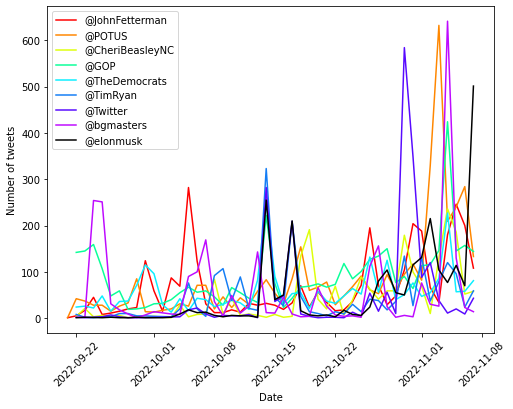

In [17]:
# Plotting the most popular mentioned users over time
fig, ax = plt.subplots(figsize = (8,6))
plot_mentions = selected_mentions['mentions'].unique()
colors = ["#ff0000","#ff8700","#deff0a","#a1ff0a","#0aff99","#0aefff","#147df5","#580aff","#be0aff","#000000"]

mentions = selected_mentions["mentions"].values
counts = selected_mentions["date"].values
dates = selected_mentions["size"].values

for mention, color in zip(plot_mentions,colors):
    if mention != "@GETTRofficial":
        idxs = np.where(mentions == mention)
        ax.plot(counts[idxs],dates[idxs], label = mention, c=color)

ax.set_xlabel('Date')
ax.set_ylabel('Number of tweets')
plt.xticks(rotation = 45)
ax.legend(loc=0)

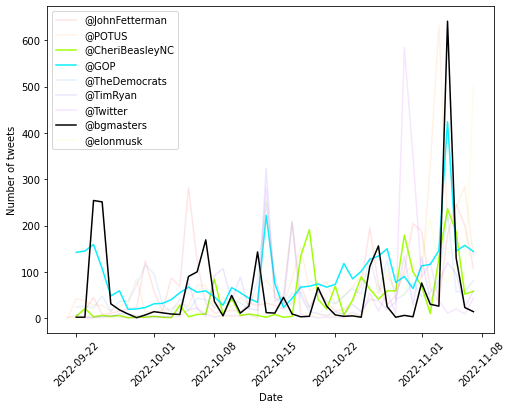

In [21]:
fig, ax = plt.subplots(figsize = (8,6))
plot_mentions = selected_mentions['mentions'].unique()
colors = ["#ff0000","#ff8700","#a1ff0a","#0aff99","#0aefff","#147df5","#580aff","#be0aff","#000000","#deff0a"]

mentions = selected_mentions["mentions"].values
counts = selected_mentions["date"].values
dates = selected_mentions["size"].values

for mention, color in zip(plot_mentions,colors):
    if mention != "@GETTRofficial":
        if mention in ['@CheriBeasleyNC','@GOP','@bgmasters']:
            idxs = np.where(mentions == mention)
            ax.plot(counts[idxs],dates[idxs], label = mention, c=color)
        else:
            idxs = np.where(mentions == mention)
            ax.plot(counts[idxs],dates[idxs], label = mention, c=color, alpha = 0.1)

ax.set_xlabel('Date')
ax.set_ylabel('Number of tweets')
plt.xticks(rotation = 45)
ax.legend(loc=0)

In [19]:
# coorelation between users being mentioned on the same day
selected_mentions.pivot(index='date', columns= 'mentions', values = "size").corr()

mentions,@CheriBeasleyNC,@GETTRofficial,@GOP,@JohnFetterman,@POTUS,@TheDemocrats,@TimRyan,@Twitter,@bgmasters,@elonmusk
mentions,,,,,,,,,,
@CheriBeasleyNC,1.000000,-0.058840,0.500995,0.391340,0.449025,0.262234,0.210384,0.250206,0.338988,0.129644
@GETTRofficial,-0.058840,1.000000,-0.080490,-0.210582,-0.246517,-0.143705,-0.037567,-0.143202,0.167680,-0.197046
@GOP,0.500995,-0.080490,1.000000,0.311756,0.403340,0.642527,0.347950,0.073183,0.677250,0.370203
@JohnFetterman,0.391340,-0.210582,0.311756,1.000000,0.253626,0.221902,0.163832,0.212464,0.282855,0.226106
@POTUS,0.449025,-0.246517,0.403340,0.253626,1.000000,0.253470,0.187959,0.094453,0.102630,0.366139
@TheDemocrats,0.262234,-0.143705,0.642527,0.221902,0.253470,1.000000,0.516009,0.265954,0.394619,0.379597
@TimRyan,0.210384,-0.037567,0.347950,0.163832,0.187959,0.516009,1.000000,0.530097,0.073816,0.500255
@Twitter,0.250206,-0.143202,0.073183,0.212464,0.094453,0.265954,0.530097,1.000000,-0.137032,0.338062
@bgmasters,0.338988,0.167680,0.677250,0.282855,0.102630,0.394619,0.073816,-0.137032,1.000000,-0.003329
